In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(1, 1000)  
        self.fc2 = nn.Linear(1000, 250)
        self.out = nn.Linear(250, 1)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = torch.relu(self.fc2(x))
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [51]:
def neuralBalance(inl, oul, rand = False, freq=1.0, order=1):
    shape = inl.weight.shape[0]
    norm = []
    
    if rand:
        ind = int(freq*shape)
        ind = np.random.choice(shape, ind, replace = False)
        indt = torch.from_numpy(ind).long()

        prev = torch.linalg.norm(inl.weight[indt], dim=1, ord=order)
        out = torch.linalg.norm(oul.weight[:,indt], dim = 0, ord=order)

        opt = torch.sqrt(prev/out)
        inl.weight[indt].data = inl.weight[indt.data]*opt.unsqueeze(1)
        oul.weight[:,indt].data = oul.weight[:,indt.data]/opt

    else:
        prev = torch.linalg.norm(inl.weight, dim=1, ord=order)
        out = torch.linalg.norm(oul.weight, dim = 0, ord=order)

        opt = torch.sqrt(prev/out)
        inl.weight.data = inl.weight*opt.unsqueeze(1)
        oul.weight.data = oul.weight/opt

In [52]:

X = torch.linspace(0, 4 * np.pi, 50).unsqueeze(-1)  
Y = torch.sin(X)  

lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

num_epochs = 10000  
for epoch in range(num_epochs):
    optimizer.zero_grad() 
    outputs = model(X)  
    loss = criterion(outputs, Y) 

    loss.backward() 
    optimizer.step() 
    
    if epoch % 100 == 0 and epoch > 400:
        for i in range(len(lay)):
            if i > 0 and i <= len(lay)-1:
                neuralBalance(lay[i-1][1], lay[i][1], rand=True, freq = 1)

    if epoch % 50 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')


Linear
Linear
Linear
Epoch 0/10000, Loss: 1.318660855293274
Epoch 50/10000, Loss: 0.4925171136856079
Epoch 100/10000, Loss: 0.48880627751350403
Epoch 150/10000, Loss: 0.4800057113170624
Epoch 200/10000, Loss: 0.4623350203037262
Epoch 250/10000, Loss: 0.42420822381973267
Epoch 300/10000, Loss: 0.37821686267852783
Epoch 350/10000, Loss: 0.3588707745075226
Epoch 400/10000, Loss: 0.3502083718776703
Epoch 450/10000, Loss: 0.34547746181488037
Epoch 500/10000, Loss: 0.3420230746269226
Epoch 550/10000, Loss: 0.3395615816116333
Epoch 600/10000, Loss: 0.33791258931159973
Epoch 650/10000, Loss: 0.3368352949619293
Epoch 700/10000, Loss: 0.3361187279224396
Epoch 750/10000, Loss: 0.3356432318687439
Epoch 800/10000, Loss: 0.33586597442626953
Epoch 850/10000, Loss: 0.3350771963596344
Epoch 900/10000, Loss: 0.3349768817424774
Epoch 950/10000, Loss: 0.3349170684814453
Epoch 1000/10000, Loss: 0.33488166332244873
Epoch 1050/10000, Loss: 0.3348580300807953
Epoch 1100/10000, Loss: 0.33484217524528503
Epoch 

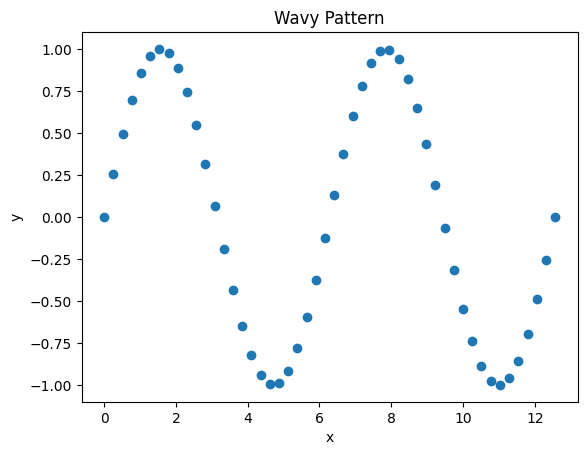

In [53]:
import numpy as np
import matplotlib.pyplot as plt

plt.scatter(X, Y)
plt.title('Wavy Pattern')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

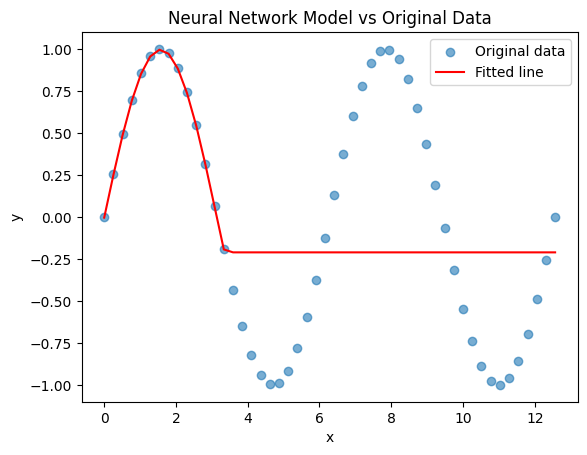

In [54]:
with torch.no_grad():
    predicted = model(X).data.numpy()

plt.scatter(X, Y, label='Original data', alpha=0.6)
plt.plot(X, predicted, label='Fitted line', color='red')
plt.legend()
plt.title('Neural Network Model vs Original Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

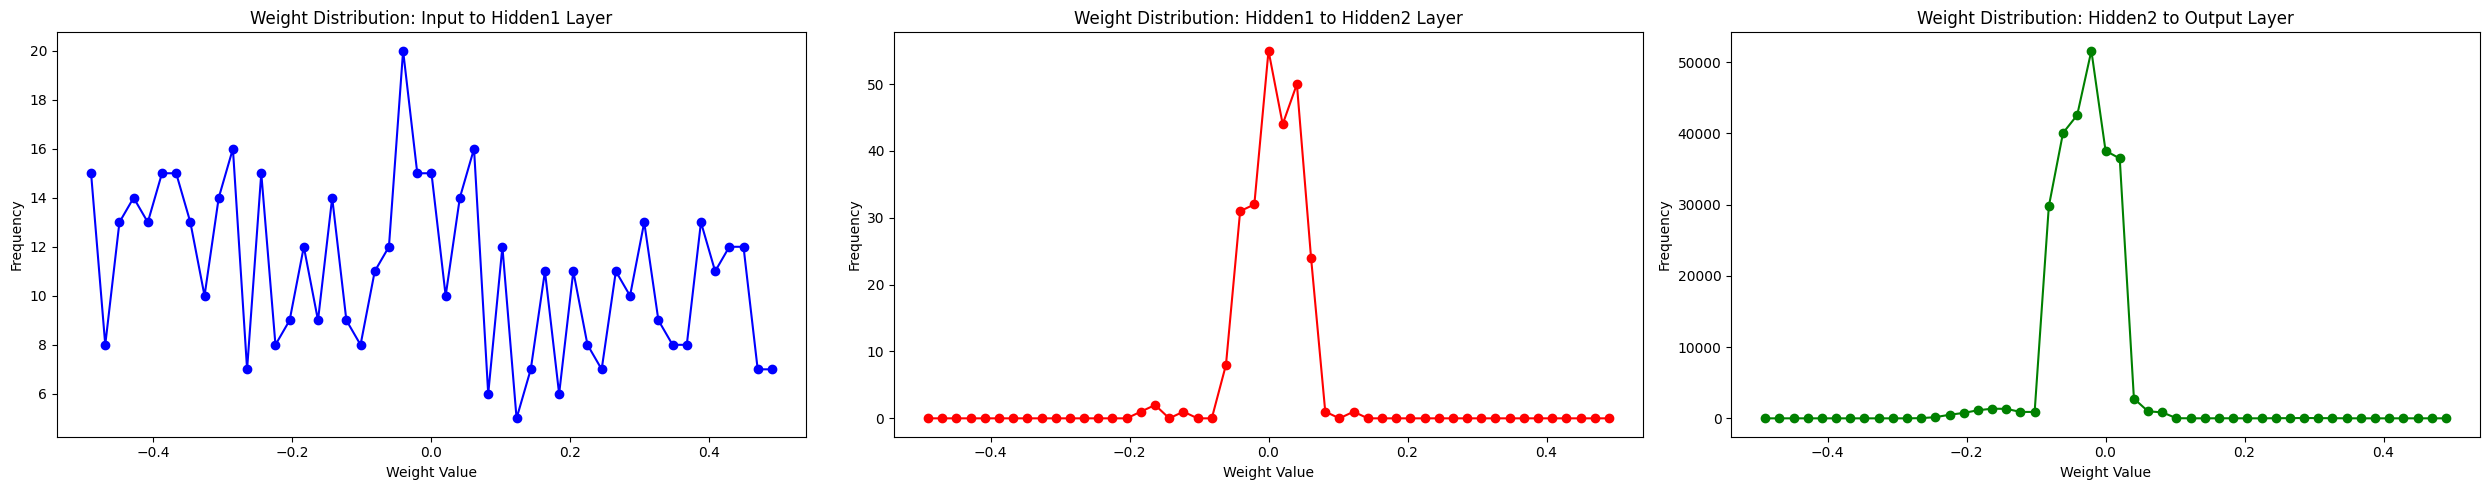

In [55]:
fc_weights = model.fc.weight.detach().numpy().flatten()
fc2_weights = model.fc2.weight.detach().numpy().flatten()
out_weights = model.out.weight.detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
fc2_hist, fc2_bins = np.histogram(fc2_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
fc2_bin_centers = 0.5 * (fc2_bins[:-1] + fc2_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='r')
plt.title('Weight Distribution: Hidden1 to Hidden2 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.plot(fc2_bin_centers, fc2_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: Hidden2 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [56]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.1):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc2 = count_nonzero_weights_above_threshold(model.fc2, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 2: {nonzero_fc2}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3}')

Number of non-zero weights greater than 0.01 in layer 1: 986
Number of non-zero weights greater than 0.01 in layer 2: 213206
Number of non-zero weights greater than 0.01 in layer 3: 198
